In [19]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#  The maximum setting: top K features： 60, WIN： 16, STEP： 288， limited on Nvidia RTX-2080ti (12G)
window = 16
step = 288
K = 60  # Number of features to keep

In [20]:
## Data processing 1
file1 = 'facility_1/facility_1_data_sm.csv'
file2 = 'facility_2/facility_2_data_sm.csv'

df1 = pl.read_csv(file1, infer_schema_length=1000000)
df2 = pl.read_csv(file2, infer_schema_length=1000000)

# Add a "coordinate" column to distinguish between the two datasets
df1 = df1.with_columns(pl.lit(True).alias("coordinate"))
df2 = df2.with_columns(pl.lit(False).alias("coordinate"))

# Find column differences between the two DataFrames
col1 = df1.columns
col2 = df2.columns
diff_df1_not_in_df2 = set(col1) - set(col2)
diff_df2_not_in_df1 = set(col2) - set(col1)

# Add missing columns with `None` values
for col in diff_df1_not_in_df2:
    if col != "coordinate":  # Skip the "coordinate" column
        df2 = df2.with_columns(pl.lit(None).alias(col))

for col in diff_df2_not_in_df1:
    if col != "coordinate":  # Skip the "coordinate" column
        df1 = df1.with_columns(pl.lit(None).alias(col))

# Align data types for common columns
common_columns = set(df1.columns) & set(df2.columns)

for col in common_columns:
    dtype1 = df1.schema[col]
    dtype2 = df2.schema[col]

    if dtype1 != dtype2:
        common_dtype = pl.Float64 if dtype1 == pl.Float64 or dtype2 == pl.Float64 else pl.Utf8
        if common_dtype == pl.Float64:
            df1 = df1.with_columns(
                pl.col(col)
                .map_elements(
                    lambda x: float(x) if str(x).replace('.', '', 1).isdigit() else None,
                    return_dtype=pl.Float64  # Specify return_dtype to avoid warnings
                )
                .alias(col)
            )
            df2 = df2.with_columns(
                pl.col(col)
                .map_elements(
                    lambda x: float(x) if str(x).replace('.', '', 1).isdigit() else None,
                    return_dtype=pl.Float64  # Specify return_dtype to avoid warnings
                )
                .alias(col)
            )

        df1 = df1.with_columns(pl.col(col).cast(common_dtype))
        df2 = df2.with_columns(pl.col(col).cast(common_dtype))

df = pl.concat([df1.select(common_columns), df2.select(common_columns)], how="vertical")

print(df.select(sorted(common_columns)).head(10))

shape: (10, 104)
┌────────────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬──────┬───────────┐
│ bop_plc_ab ┆ bop_plc_ab ┆ bop_plc_ab ┆ bop_plc_ab ┆ … ┆ bop_plc_v ┆ coordinat ┆ rn   ┆ timestamp │
│ b_gc_commu ┆ b_gc_outle ┆ b_gc_outle ┆ b_gc_outle ┆   ┆ l_comp_vo ┆ e         ┆ ---  ┆ ---       │
│ nicationst ┆ tstream_ch ┆ tstream_co ┆ tstream_fl ┆   ┆ lumeslide ┆ ---       ┆ i64  ┆ str       │
│ …          ┆ …          ┆ …          ┆ …          ┆   ┆ _po…      ┆ bool      ┆      ┆           │
│ ---        ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---       ┆           ┆      ┆           │
│ bool       ┆ f64        ┆ f64        ┆ f64        ┆   ┆ f64       ┆           ┆      ┆           │
╞════════════╪════════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪══════╪═══════════╡
│ true       ┆ 73.650002  ┆ 24.809999  ┆ 60.700001  ┆ … ┆ 70.434784 ┆ true      ┆ 300  ┆ 2023-03-3 │
│            ┆            ┆            ┆            ┆   ┆           ┆     

In [21]:
## Dataset processing 2

# 1. Handle boolean columns (convert to int32)
df = df.with_columns([
    pl.col(col).cast(pl.Int32).fill_null(0) if df[col].dtype == pl.Boolean else pl.col(col)
    for col in df.columns
])

# 2. Replace 'NULL' strings and handle string columns
df = df.with_columns([
    pl.when(pl.col(col) == "NULL")
    .then(None)
    .otherwise(pl.col(col))
    .cast(pl.Categorical)
    .to_physical()
    .fill_null(-1)
    .alias(col)
    for col in df.columns if df[col].dtype == pl.Utf8
])

# 3. Enhanced null handling for numeric columns
for col in df.columns:
    dtype = df[col].dtype

    if dtype.is_numeric():
        if df[col].is_null().all():
            df = df.with_columns(pl.col(col).fill_null(0))
        else:
            median_val = df[col].median()
            df = df.with_columns(
                pl.col(col)
                .fill_null(median_val)
                .clip(float('-inf'), float('inf'))
            )

# 4. Final verification
null_sum = df.null_count().select(pl.sum_horizontal(pl.all())).item()
if null_sum > 0:
    raise ValueError("Null values remain in the DataFrame.")

inf_sum = df.select(pl.all().is_infinite().sum()).select(pl.sum_horizontal(pl.all())).item()
if inf_sum > 0:
    raise ValueError("Infinite values detected in the DataFrame.")

print("Success: No nulls or infinities in the DataFrame")


Success: No nulls or infinities in the DataFrame


<Figure size 1800x1000 with 0 Axes>

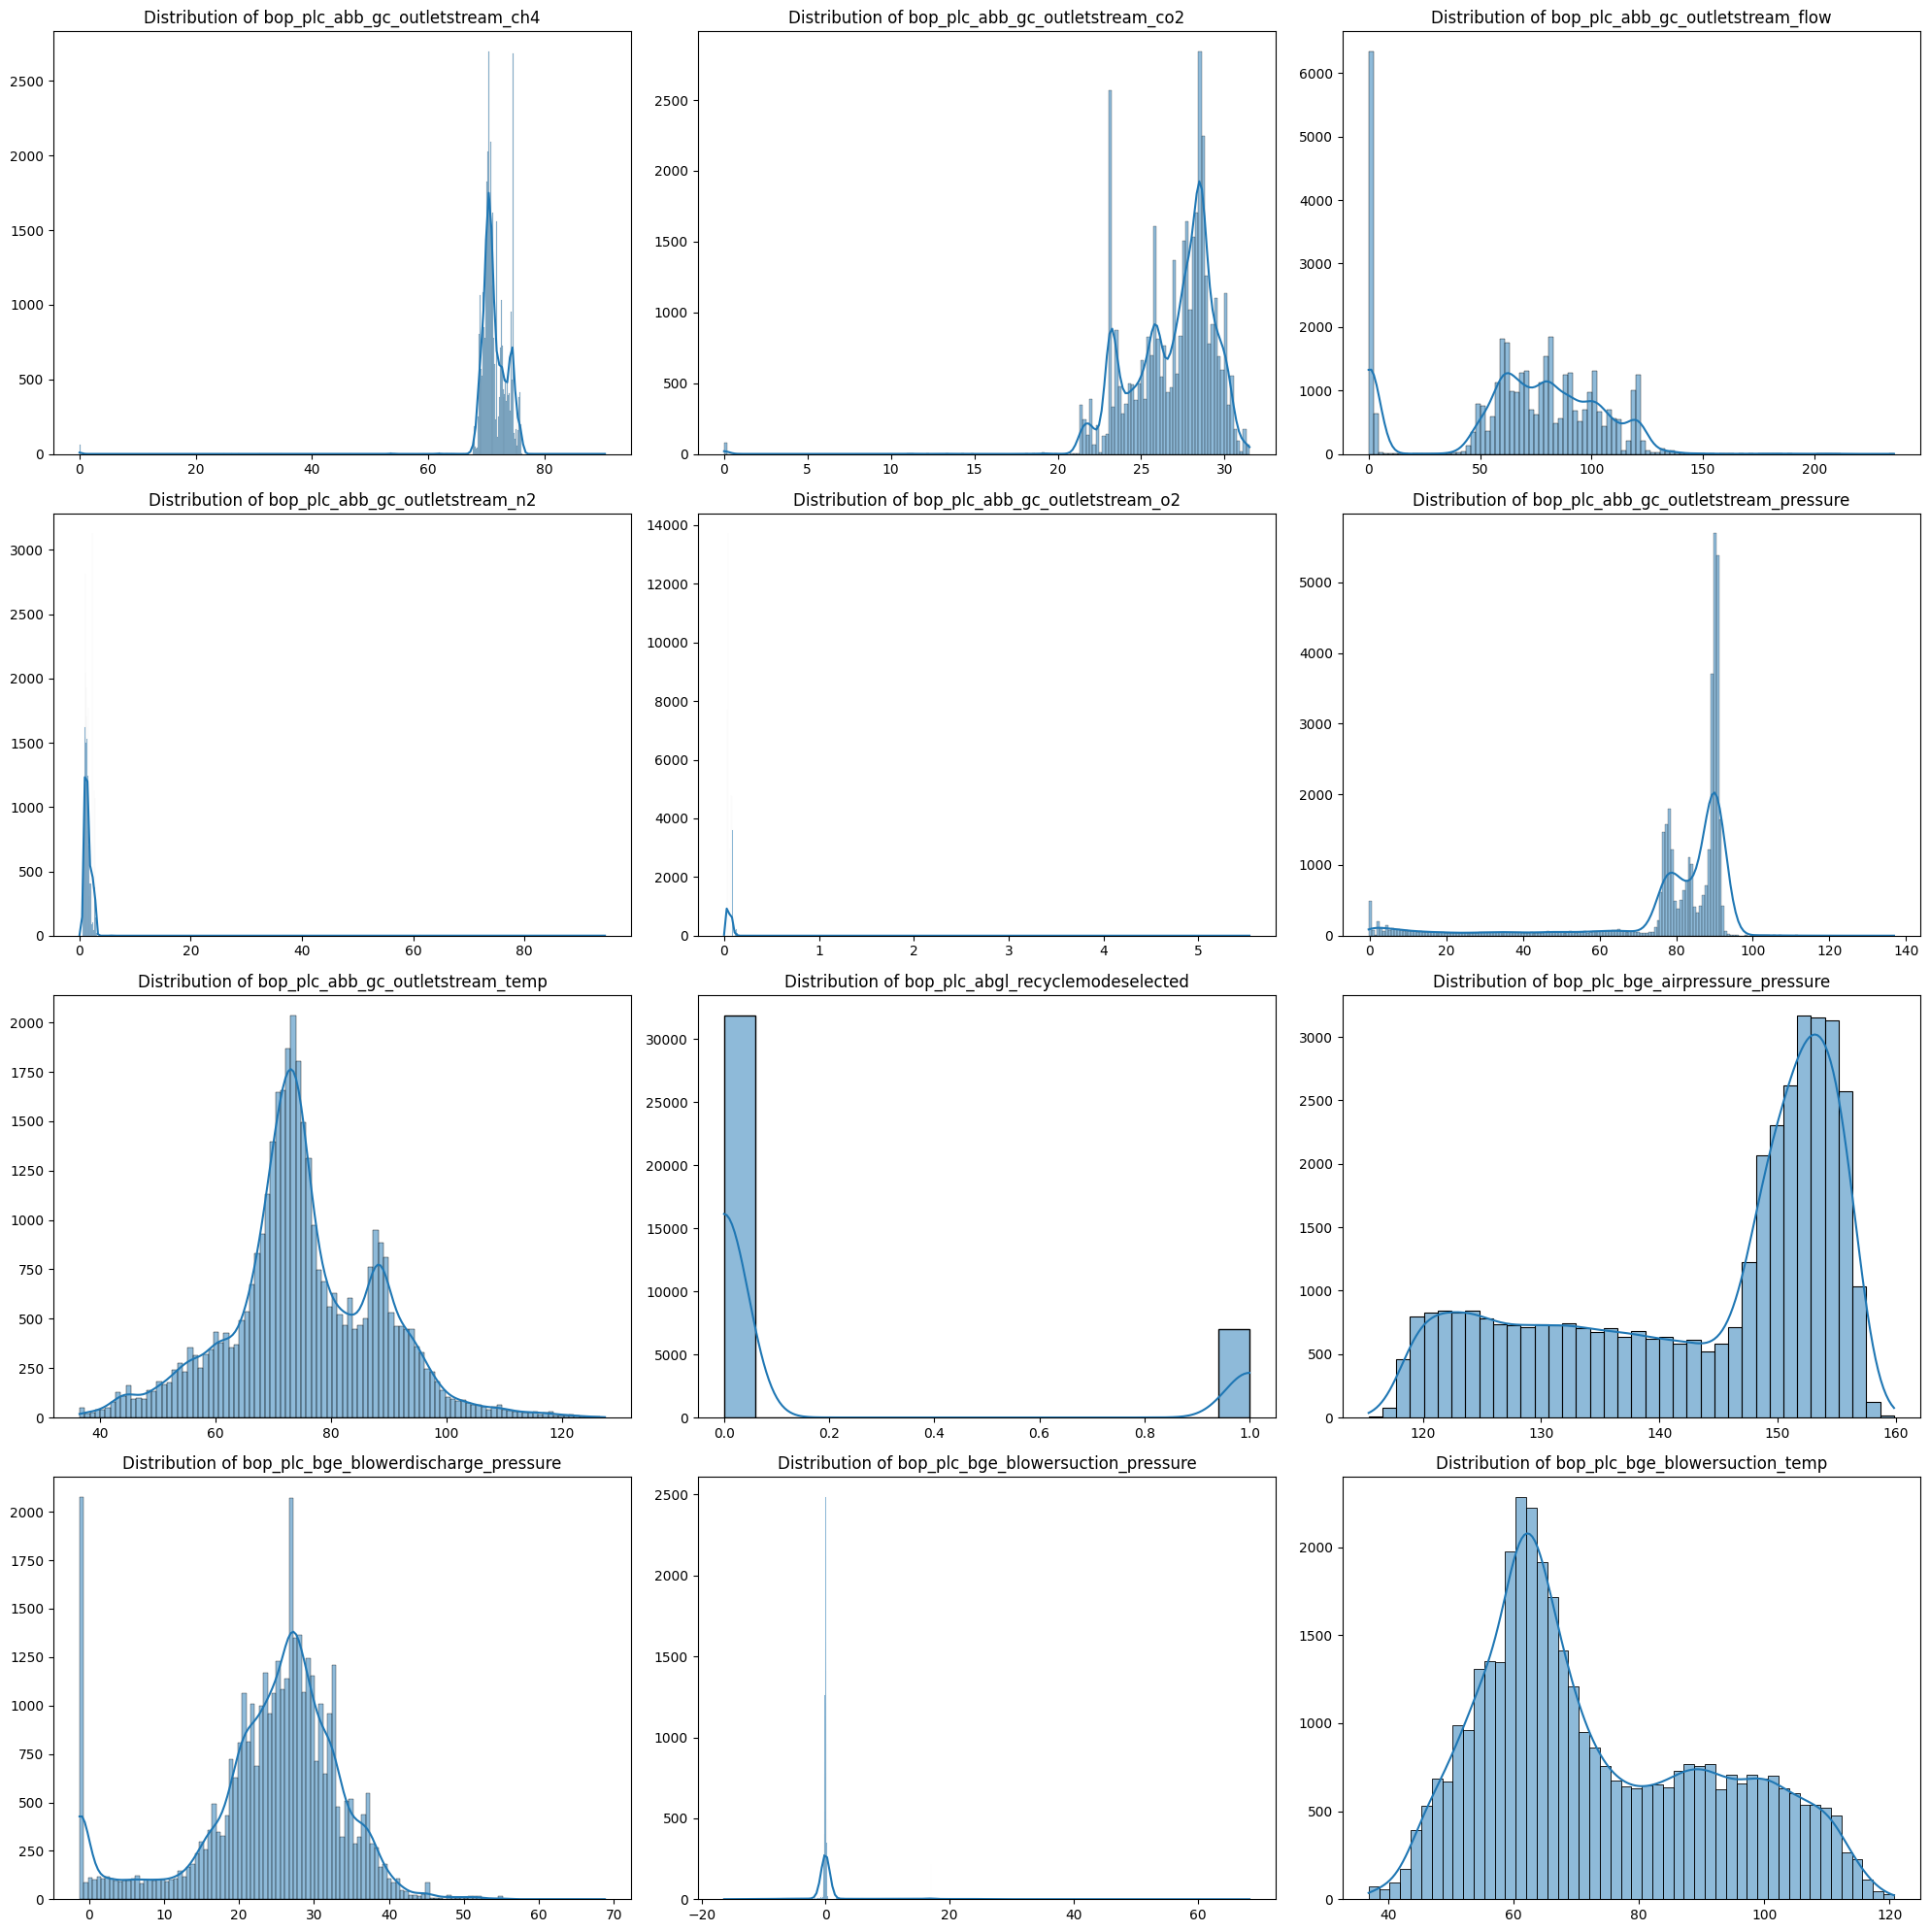

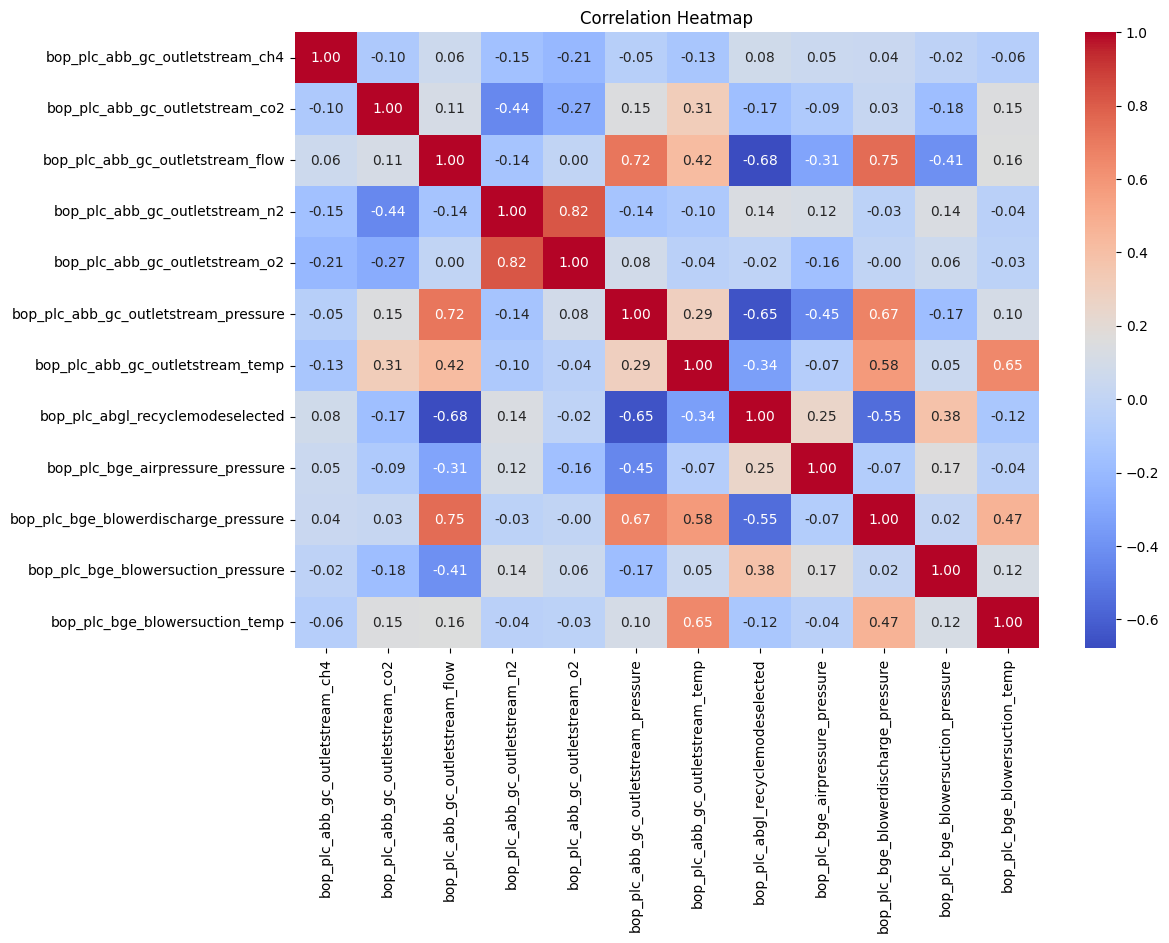

In [22]:
# Data visualization, picked up few main features
columns_to_visualize = [
    "bop_plc_abb_gc_outletstream_ch4",
    "bop_plc_abb_gc_outletstream_co2",
    "bop_plc_abb_gc_outletstream_flow",
    "bop_plc_abb_gc_outletstream_n2",
    "bop_plc_abb_gc_outletstream_o2",
    "bop_plc_abb_gc_outletstream_pressure",
    "bop_plc_abb_gc_outletstream_temp",
    "bop_plc_abgl_recyclemodeselected",
#     "bop_plc_bge_accumruntime",
    "bop_plc_bge_airpressure_pressure",
    "bop_plc_bge_blowerdischarge_pressure",
    "bop_plc_bge_blowersuction_pressure",
    "bop_plc_bge_blowersuction_temp"
]

df_filtered = df.select(columns_to_visualize)

plt.figure(figsize=(18, 10))
n_rows = 4
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
axes = axes.flatten()

for i, column in enumerate(df_filtered.columns):
    if i < len(axes):
        sns.histplot(df_filtered[column].to_numpy(), kde=True, ax=axes[i])
        axes[i].set_title(f"Distribution of {column}")
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")

plt.tight_layout()
plt.show()

# Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df_filtered.to_pandas().corr()  # 计算相关性矩阵
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [31]:
# Label generation
methane_percentage = df["bop_plc_abb_gc_outletstream_ch4"]
flow_rate = df["bop_plc_abb_gc_outletstream_flow"]
is_running = df["bop_plc_bge_skid_running"]

duration_minutes = 5  # interval by samples is 5 minutes
norm_factor = 10000
# Calculate the energy output as label
energy_output = (
    flow_rate * duration_minutes *
    (methane_percentage / 100) *1010
    /norm_factor  ## to normalize
)

df = df.with_columns(
    energy_output.alias("energy_output")
)

# df = df.with_columns(
#     pl.when(is_running).then(energy_output).otherwise(pl.lit(None)).alias("energy_output")
# )

print(df.head())

shape: (5, 105)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ bop_plc_a ┆ bop_plc_v ┆ bop_plc_v ┆ bop_plc_v ┆ … ┆ bop_plc_c ┆ bop_plc_a ┆ timestamp ┆ energy_o │
│ bb_gc_out ┆ l_comp_ne ┆ l_comp_co ┆ l_comp_co ┆   ┆ h800_chil ┆ hu900_air ┆ ---       ┆ utput    │
│ letstream ┆ toildiff_ ┆ mpfan_run ┆ mpfan_fau ┆   ┆ ler_runti ┆ comp_runc ┆ f64       ┆ ---      │
│ _pr…      ┆ pre…      ┆ cmd       ┆ lts…      ┆   ┆ mer       ┆ md        ┆           ┆ f64      │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆           ┆          │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 90.760002 ┆ 86.521164 ┆ 1.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 22.57630 │
│           ┆           ┆           ┆           ┆   ┆           ┆          

In [32]:
# Feature selection 1 -  Feature to feature co-relationship analysis (Better than feature to label approach)
corr_matrix = df.select(pl.corr(pl.all(), pl.all())).fill_nan(0)
target = "energy_output"  
# K = 48  # Number of features to keep

top_features = (
    corr_matrix
    .with_columns(pl.all().name.prefix("corr_"))  # Add prefix to avoid name conflicts
    .melt(variable_name="feature", value_name="correlation")
    .filter(pl.col("feature") != f"corr_{target}")  # Exclude target's self-correlation
    .with_columns(
        pl.col("correlation").abs().alias("abs_corr"),
        pl.col("feature").str.replace("^corr_", "")
    )
    .sort("abs_corr", descending=True)
    .head(K)
    .get_column("feature")
    .to_list()
)

# Ensure 'bop_plc_bge_skid_running' is always included in the selected features
if "bop_plc_bge_skid_running" not in top_features:
    top_features.append("bop_plc_bge_skid_running")

# Select the target, top features, and ensure 'bop_plc_bge_skid_running' is included
df_selected = df.select([target] + top_features)

print(f"Selected features: {top_features}")
print(df_selected)

Selected features: ['bop_plc_abb_gc_outletstream_pressure', 'bop_plc_vl_comp_netoildiff_pressure', 'bop_plc_vl_comp_compfan_runcmd', 'bop_plc_bge_pd_h2s', 'bop_plc_bge_dscrubber_conddrainvalve_open', 'bop_plc_inr_fc_todayvolume_mcf_real', 'bop_plc_vl_comp_mainmotor_amps', 'bop_plc_bge_pipelinevalve_opencmd', 'bop_plc_vl_comp_suction_pressure', 'bop_plc_vl_comp_oilcoolervfd_speed', 'bop_plc_bge_reheateroutlet_temp', 'bop_plc_inr_fc_accvolume_real', 'bop_plc_bge_pressurerun_target_sp', 'bop_plc_vl_comp_runstatus', 'bop_plc_bge_flowrun_target_sp', 'bop_plc_vl_comp_oilseperator_temp', 'bop_plc_vl_comp_runcmd', 'bop_plc_vl_comp_volumeslide_position', 'bop_plc_bge_inletvalve_closed', 'rn', 'bop_plc_bge_inletvalve_opencmd', 'bop_plc_vl_comp_capacityslide_position', 'bop_plc_bge_pv0109_targetsp', 'bop_plc_bge_pipelinevalve_open', 'bop_plc_bge_sump_topsensor_level', 'bop_plc_abb_gc_communicationstatus', 'bop_plc_bge_skid_running', 'bop_plc_bge_sump_bottomsensor_level_ina', 'bop_plc_vl_comp_disc

In [33]:
# # Feature selection 2 -  Feature to label co-relationship analysis
# # Keep "bop_plc_bge_skid_running" anyway

# # Compute correlation of each feature with the target
# target = "energy_output"
## K = 48 # Number of features to keep

# # Calculate correlation of each column with the target
# corr_with_target = (
#     df.select(
#         [pl.corr(pl.col(feature), pl.col(target)).alias(feature) for feature in df.columns if feature != target]
#     )
#     .melt(variable_name="feature", value_name="correlation")
#     .with_columns(pl.col("correlation").abs().alias("abs_corr"))  # Use absolute correlation
#     .sort("abs_corr", descending=True)  # Sort by absolute correlation (descending)
#     .head(K)  # Keep the top K features
#     .get_column("feature")  # Extract the feature names
#     .to_list()
# )

# # Ensure 'bop_plc_bge_skid_running' is always included in the selected features
# if "bop_plc_bge_skid_running" not in corr_with_target:
#     corr_with_target.append("bop_plc_bge_skid_running")

# # Select the target and the top K features
# df_selected = df.select([target] + corr_with_target)

# print(f"Selected features: {corr_with_target}")
# print(df_selected)

In [34]:
# Dataset generation


#  The maximum setting: top K features： 48, WIN： 72, STEP： 288， limited on Nvidia GTX-2080ti (12G)
# window = 72
# step = 288


def generate_time_series_samples_pl(df: pl.DataFrame, win: int, step: int, target='energy_output'):
    feature_cols = [col for col in df.columns if col != target]
    
    # Convert to numpy arrays
    features = df[feature_cols].to_numpy()
    targets = df[target].to_numpy()
    
    X = []
    y = []

    for i in range(len(features) - win - step + 1):
        x_window = features[i:i+win]  # Feature window
        y_label = targets[i+win+step-1]  # Future target value
        X.append(x_window)
        y.append(y_label)

    return np.array(X), np.array(y)

X, y = generate_time_series_samples_pl(df_selected, win=window, step=step, target ='energy_output')

# Remove the "timestamp" as feature
X_columns = df_selected.columns
if "timestamp" in X_columns:
    timestamp_column_idx = X_columns.index("timestamp")
    X = np.delete(X, timestamp_column_idx, axis=2)  # Remove timestamp column from feature set

# Check the types before converting to float32
print(f"X type before split: {X.dtype}, y type: {y.dtype}")

X = np.nan_to_num(X, nan=np.nan)  # Convert NaN to numeric value, e.g., zero or the mean
y = np.nan_to_num(y, nan=np.nan)  # Similarly handle NaN in y

X = X.astype(np.float32)  
y = y.astype(np.float32) 

# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Output data shapes for confirmation
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')

# Convert to PyTorch tensors and ensure the correct type (float32)
X_train_tensor = torch.tensor(X_train).float() 
X_val_tensor = torch.tensor(X_val).float()      
y_train_tensor = torch.tensor(y_train).float()
y_val_tensor = torch.tensor(y_val).float()

X type before split: float64, y type: float64
X_train shape: (30881, 16, 60), y_train shape: (30881,)
X_val shape: (7721, 16, 60), y_val shape: (7721,)


In [35]:
# Build model
class ResidualLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        # Linear projection for residual connection if dimensions change
        self.proj = nn.Linear(input_size, hidden_size) if input_size != hidden_size else None
        
    def forward(self, x):
        # Get LSTM output
        out, _ = self.lstm(x)
        
        # Add residual connection if needed
        if self.proj is not None:
            residual = self.proj(x)
        else:
            residual = x
            
        return out + residual

class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=3, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        
        # First LSTM layer (special case for input size)
        self.lstm_layers = nn.ModuleList([
            ResidualLSTM(input_size, hidden_size)
        ])
        
        # Additional LSTM layers
        for _ in range(num_layers - 1):
            self.lstm_layers.append(ResidualLSTM(hidden_size, hidden_size))
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # Initial residual is the input features repeated for each time step
        residual = x
        
        for lstm in self.lstm_layers:
            x = lstm(x)
            x = self.dropout(x)
        
        # Take last time step's output
        out = self.fc(x[:, -1, :])
        return out.squeeze()

input_size = X_train.shape[2]  # number of feature
model = LSTMRegressor(input_size=input_size)

Using device: cuda
Epoch [0/5000] | Train Loss: 37169164288.0000 | Val MSE: 3126342656.0000 | LR: 0.001000
Epoch [10/5000] | Train Loss: 25896558592.0000 | Val MSE: 188221600.0000 | LR: 0.000993
Epoch [20/5000] | Train Loss: 19510603776.0000 | Val MSE: 155765344.0000 | LR: 0.000973
Epoch [30/5000] | Train Loss: 14664421376.0000 | Val MSE: 49114856.0000 | LR: 0.000942
Epoch [40/5000] | Train Loss: 11240913920.0000 | Val MSE: 21418980.0000 | LR: 0.000900
Epoch [50/5000] | Train Loss: 8481967104.0000 | Val MSE: 4966001.0000 | LR: 0.000848
Epoch [60/5000] | Train Loss: 6741368832.0000 | Val MSE: 1219601.3750 | LR: 0.000788
Epoch [70/5000] | Train Loss: 5486754304.0000 | Val MSE: 1596525.2500 | LR: 0.000720
Epoch [80/5000] | Train Loss: 4694796288.0000 | Val MSE: 760640.5625 | LR: 0.000647
Epoch [90/5000] | Train Loss: 4003432192.0000 | Val MSE: 872160.0625 | LR: 0.000570
Epoch [100/5000] | Train Loss: 3510802176.0000 | Val MSE: 600405.7500 | LR: 0.000492
Epoch [110/5000] | Train Loss: 3119

Epoch [990/5000] | Train Loss: 10868944.0000 | Val MSE: 20388.9043 | LR: 0.000005
Epoch [1000/5000] | Train Loss: 10929474.0000 | Val MSE: 20385.1289 | LR: 0.000000
Epoch [1010/5000] | Train Loss: 11004426.0000 | Val MSE: 20386.1348 | LR: 0.000007
Epoch [1020/5000] | Train Loss: 11057031.0000 | Val MSE: 20341.1738 | LR: 0.000027
Epoch [1030/5000] | Train Loss: 10911645.0000 | Val MSE: 20285.1035 | LR: 0.000058
Epoch [1040/5000] | Train Loss: 10789008.0000 | Val MSE: 20234.4590 | LR: 0.000100
Epoch [1050/5000] | Train Loss: 10791591.0000 | Val MSE: 20111.0820 | LR: 0.000152
Epoch [1060/5000] | Train Loss: 10779161.0000 | Val MSE: 19829.5137 | LR: 0.000212
Epoch [1070/5000] | Train Loss: 10410538.0000 | Val MSE: 20416.1211 | LR: 0.000280
Epoch [1080/5000] | Train Loss: 10227088.0000 | Val MSE: 19195.8496 | LR: 0.000353
Epoch [1090/5000] | Train Loss: 10003602.0000 | Val MSE: 18893.5488 | LR: 0.000430
Epoch [1100/5000] | Train Loss: 9677889.0000 | Val MSE: 18331.3340 | LR: 0.000508
Epoch 

Epoch [2000/5000] | Train Loss: 893160.8750 | Val MSE: 2172.2808 | LR: 0.001000
Epoch [2010/5000] | Train Loss: 897744.6250 | Val MSE: 2202.6084 | LR: 0.000993
Epoch [2020/5000] | Train Loss: 860780.1250 | Val MSE: 1933.6836 | LR: 0.000973
Epoch [2030/5000] | Train Loss: 825797.8125 | Val MSE: 1681.9827 | LR: 0.000942
Epoch [2040/5000] | Train Loss: 823131.5000 | Val MSE: 1706.7953 | LR: 0.000900
Epoch [2050/5000] | Train Loss: 793370.8125 | Val MSE: 1589.1631 | LR: 0.000848
Epoch [2060/5000] | Train Loss: 770324.2500 | Val MSE: 1801.0853 | LR: 0.000788
Epoch [2070/5000] | Train Loss: 753219.1250 | Val MSE: 1540.0120 | LR: 0.000720
Epoch [2080/5000] | Train Loss: 744350.5000 | Val MSE: 1495.8571 | LR: 0.000647
Epoch [2090/5000] | Train Loss: 759127.5625 | Val MSE: 1511.4652 | LR: 0.000570
Epoch [2100/5000] | Train Loss: 729731.8750 | Val MSE: 1440.1714 | LR: 0.000492
Epoch [2110/5000] | Train Loss: 715148.1250 | Val MSE: 1497.7402 | LR: 0.000414
Epoch [2120/5000] | Train Loss: 705072.6

Epoch [3040/5000] | Train Loss: 323054.7500 | Val MSE: 669.3658 | LR: 0.000100
Epoch [3050/5000] | Train Loss: 316103.7500 | Val MSE: 684.8102 | LR: 0.000152
Epoch [3060/5000] | Train Loss: 314090.4688 | Val MSE: 637.4397 | LR: 0.000212
Epoch [3070/5000] | Train Loss: 316961.6250 | Val MSE: 656.4907 | LR: 0.000280
Epoch [3080/5000] | Train Loss: 311415.6875 | Val MSE: 649.7762 | LR: 0.000353
Epoch [3090/5000] | Train Loss: 309353.3125 | Val MSE: 636.8726 | LR: 0.000430
Epoch [3100/5000] | Train Loss: 313357.5938 | Val MSE: 646.0367 | LR: 0.000508
Epoch [3110/5000] | Train Loss: 309198.4688 | Val MSE: 640.4208 | LR: 0.000586
Epoch [3120/5000] | Train Loss: 306301.5625 | Val MSE: 745.4476 | LR: 0.000662
Epoch [3130/5000] | Train Loss: 298931.8750 | Val MSE: 633.4352 | LR: 0.000734
Epoch [3140/5000] | Train Loss: 300244.0938 | Val MSE: 603.4213 | LR: 0.000800
Epoch [3150/5000] | Train Loss: 294958.4062 | Val MSE: 591.7343 | LR: 0.000859
Epoch [3160/5000] | Train Loss: 289539.3438 | Val MS

Epoch [4080/5000] | Train Loss: 123447.3750 | Val MSE: 388.6023 | LR: 0.000647
Epoch [4090/5000] | Train Loss: 121406.4844 | Val MSE: 370.4923 | LR: 0.000570
Epoch [4100/5000] | Train Loss: 123004.4141 | Val MSE: 388.2461 | LR: 0.000492
Epoch [4110/5000] | Train Loss: 122810.6641 | Val MSE: 368.3334 | LR: 0.000414
Epoch [4120/5000] | Train Loss: 121542.7188 | Val MSE: 370.0073 | LR: 0.000338
Epoch [4130/5000] | Train Loss: 121616.8516 | Val MSE: 369.1682 | LR: 0.000266
Epoch [4140/5000] | Train Loss: 118522.7656 | Val MSE: 371.2196 | LR: 0.000200
Epoch [4150/5000] | Train Loss: 117597.5312 | Val MSE: 365.6929 | LR: 0.000141
Epoch [4160/5000] | Train Loss: 117449.1250 | Val MSE: 383.8483 | LR: 0.000091
Epoch [4170/5000] | Train Loss: 117946.5156 | Val MSE: 365.0743 | LR: 0.000051
Epoch [4180/5000] | Train Loss: 119648.5156 | Val MSE: 365.9860 | LR: 0.000022
Epoch [4190/5000] | Train Loss: 118935.4688 | Val MSE: 368.4327 | LR: 0.000005
Epoch [4200/5000] | Train Loss: 118779.4297 | Val MS

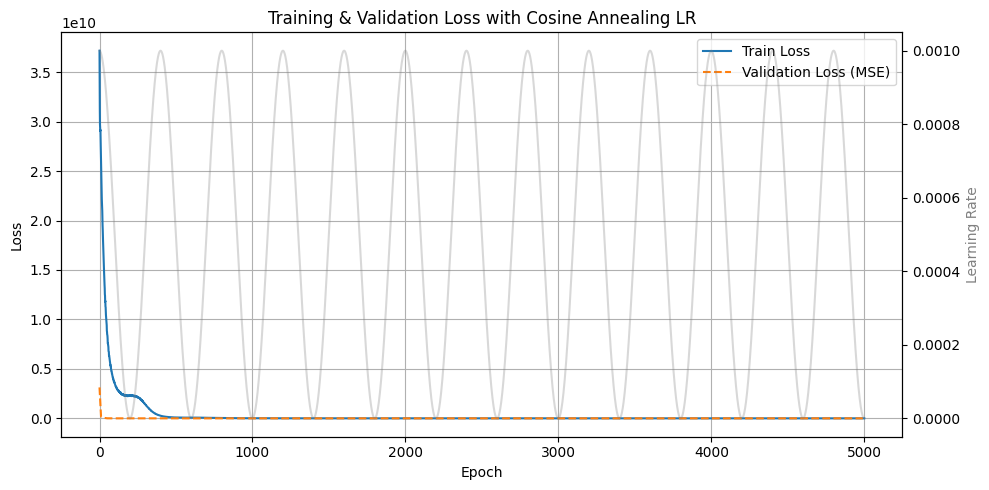

In [36]:
# Train and evaluate

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move model and data to device
model = model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# Track losses
train_losses = []
val_losses = []
lr_schedule = []

# Training loop
epochs = 5000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()

    train_losses.append(loss.item())
    lr_schedule.append(optimizer.param_groups[0]['lr'])

    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor)
            val_loss = mean_squared_error(y_val_tensor.cpu().numpy(), y_val_pred.cpu().numpy())
            val_losses.append(val_loss)
            print(f"Epoch [{epoch}/{epochs}] | Train Loss: {loss.item():.4f} | Val MSE: {val_loss:.4f} | LR: {lr_schedule[-1]:.6f}")

# Plot losses and LR
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(range(0, epochs, 10), val_losses, label='Validation Loss (MSE)', linestyle='--')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')
ax1.grid(True)

# Add LR plot
ax2 = ax1.twinx()
ax2.plot(lr_schedule, label='LR', color='gray', alpha=0.3)
ax2.set_ylabel('Learning Rate', color='gray')

plt.title('Training & Validation Loss with Cosine Annealing LR')
plt.tight_layout()
plt.show()


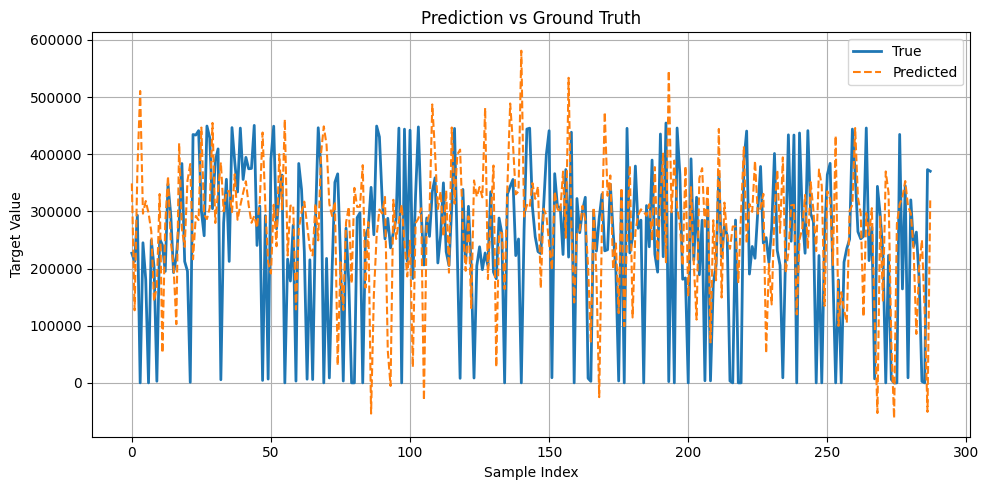

In [37]:
# Visualize the prediction
import matplotlib.pyplot as plt

# Denormalize to actual label value
y_true = y_val_tensor.cpu().numpy()[:288] * norm_factor
y_pred = y_val_pred.cpu().numpy()[:288] * norm_factor

# Plot: Predicted vs True
plt.figure(figsize=(10, 5))
plt.plot(y_true, label='True', linewidth=2)
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title('Prediction vs Ground Truth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
# GPU memory release
import gc
gc.collect()
torch.cuda.empty_cache()